In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import SGD

from toss.data import DataSet, DataBunch
from toss.callbacks import BatchTransformCallback, CudaCallback, AvgStatsCallback, Recorder, ParamScheduler, LRFinder
from toss.metrics import accuracy
from toss.misc import get_mnist, normalize, mnist_resize, get_cnn_model, append_stats
from toss.train import Trainer
from toss.optimizers import Optimizer
from toss.scheduling import combine_scheds, sched_cos,sched_lin
from toss.layers import GeneralReLU
from toss.hooks import Hooks, plot_hooks, plot_hooks_act, plot_hooks_min_act

In [21]:
x_train, y_train, x_valid, y_valid = get_mnist()
x_train, x_valid = normalize(x_train, x_valid)

BATCH_SIZE = 512
N_CLASSES = y_train.max() + 1
LOSS_FUNC = F.cross_entropy

train_ds = DataSet(x_train, y_train)
valid_ds = DataSet(x_valid, y_valid)

data = DataBunch(train_ds, valid_ds, batch_size=BATCH_SIZE, n_output=N_CLASSES)

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom = mom
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): 
                m,v = self.update_stats(x)
        else: 
            m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [ ]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralReLU(**kwargs)]
    if bn: 
#         layers.append(BatchNorm(nf))
        layers.append(LayerNorm(nf))
#           layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [ ]:
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = nn.init.kaiming_uniform_ if uniform else nn.init.kaiming_normal_
    init_cnn_(m, f)

In [36]:
sched = combine_scheds([0.3, 0.7],[sched_lin(0.6, 2.),sched_lin(2., 0.1)])
nfs = [8, 16, 32, 64, 64]

cbfs = [Recorder(),
        partial(AvgStatsCallback, accuracy),
        CudaCallback(),
        partial(ParamScheduler, "lr",sched),
        partial(BatchTransformCallback, mnist_resize)
       ]

model = get_cnn_model(data, nfs, conv_layer, 
#                       upper_bound=6.,
                      leak=0.1
                     )
init_cnn(model)
opt = SGD(model.parameters(), lr=.6)
trainer = Trainer(model, data, LOSS_FUNC, opt=opt, cbs=cbfs)

In [49]:
from toss.layers import Lambda
from toss.utils import flatten
def conv_layer(ni, nf, ks, stride):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=False),
             nn.ReLU(), nn.BatchNorm2d(nf)]
    return nn.Sequential(*layers)


class QNetwork(nn.Module):
    def __init__(self, channels_in, n_actions, n_filters=[8, 16, 32, 32]):
        super().__init__()
        n_filters = [channels_in] + n_filters
        layers = [conv_layer(n_filters[i], n_filters[i + 1], 5 if i == 0 else 3, 2)
                  for i in range(len(n_filters) - 1)]
        layers += [nn.AdaptiveAvgPool2d(1),
                   Lambda(flatten),
                   nn.Linear(n_filters[-1], n_actions)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [50]:
model = QNetwork(3, 10, [8, 16, 32, 64, 64])

In [51]:
model

QNetwork(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stri

In [52]:
x = torch.randn((3, 210, 160))
x.shape

torch.Size([3, 210, 160])

In [53]:
x.unsqueeze(0).shape

torch.Size([1, 3, 210, 160])

In [54]:
model(x.unsqueeze(0))

tensor([[-0.0578, -0.0214,  0.0620,  0.1167,  0.0495, -0.0607, -0.0315, -0.1093,
          0.0145, -0.0770]], grad_fn=<AddmmBackward>)

In [37]:
with Hooks(model[:5], append_stats) as hooks:
    trainer.fit(8)

Epoch: 1
	train : [0.31748537109375, tensor(0.9038, device='cuda:0')]
	valid : [0.251640283203125, tensor(0.9168, device='cuda:0')]
Epoch: 2
	train : [0.10945529296875, tensor(0.9659, device='cuda:0')]
	valid : [0.19546617431640625, tensor(0.9386, device='cuda:0')]
Epoch: 3
	train : [0.075114599609375, tensor(0.9762, device='cuda:0')]
	valid : [0.12359755859375, tensor(0.9618, device='cuda:0')]
Epoch: 4
	train : [0.05115998046875, tensor(0.9837, device='cuda:0')]
	valid : [0.10636402587890625, tensor(0.9686, device='cuda:0')]
Epoch: 5
	train : [0.03838745361328125, tensor(0.9882, device='cuda:0')]
	valid : [0.060415625, tensor(0.9821, device='cuda:0')]
Epoch: 6
	train : [0.02908944580078125, tensor(0.9912, device='cuda:0')]
	valid : [0.0517572265625, tensor(0.9849, device='cuda:0')]
Epoch: 7
	train : [0.02445877685546875, tensor(0.9927, device='cuda:0')]
	valid : [0.04956673278808594, tensor(0.9861, device='cuda:0')]
Epoch: 8
	train : [0.0205970068359375, tensor(0.9939, device='cuda:0'

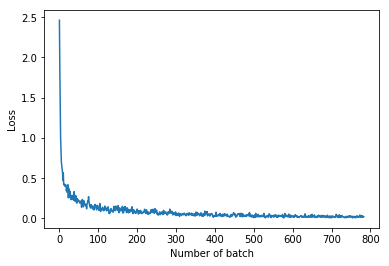

In [38]:
trainer.recorder.plot_loss()

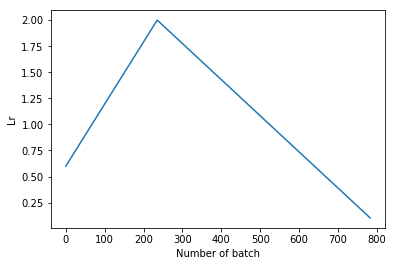

In [39]:
trainer.recorder.plot_lr()

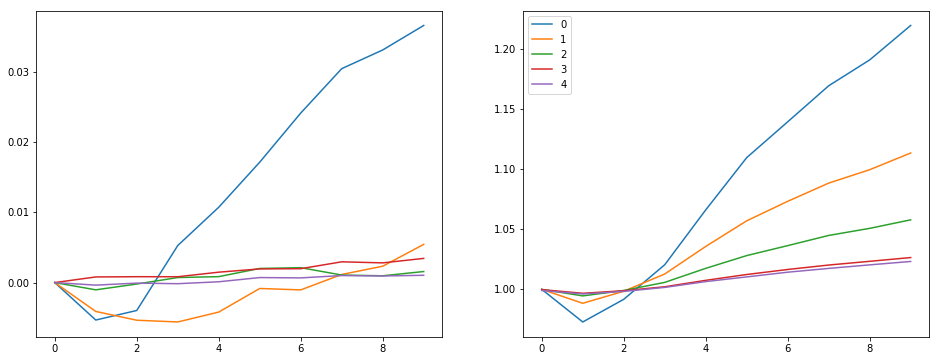

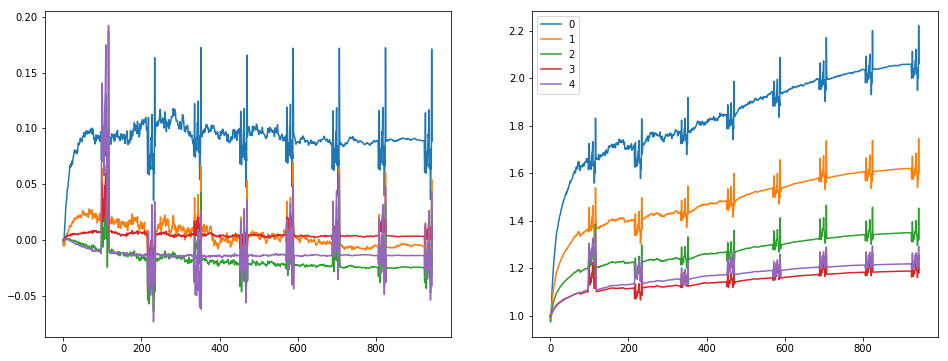

In [40]:
plot_hooks(hooks)

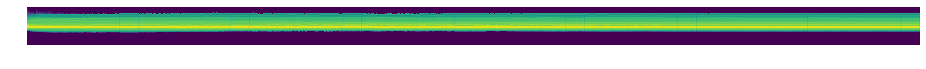

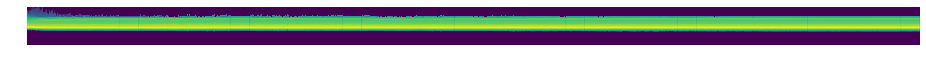

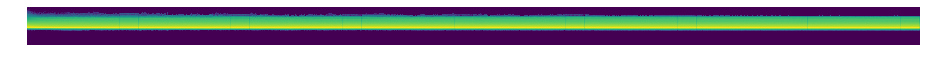

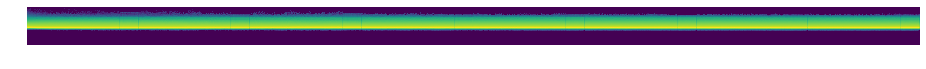

In [32]:
plot_hooks_act(hooks)

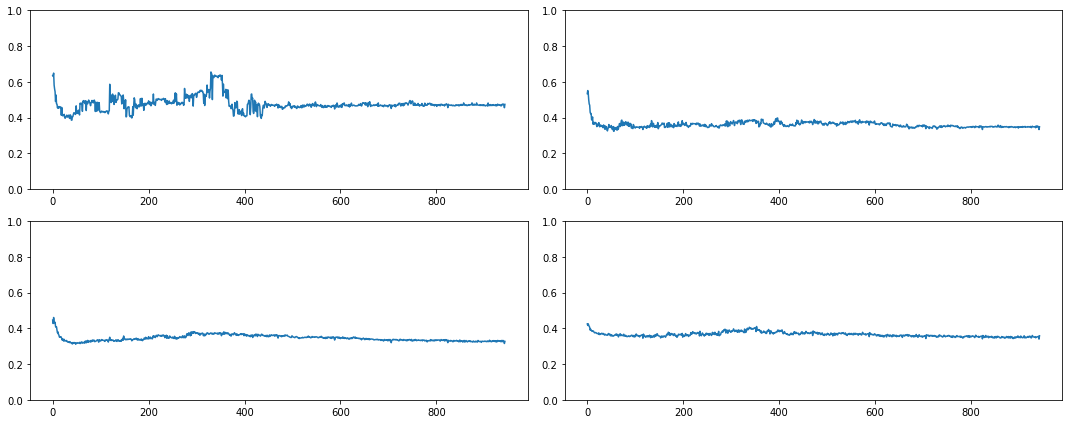

In [33]:
plot_hooks_min_act(hooks)

In [41]:
class LayerNorm(nn.Module):
    __constants__ = ["eps"]
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps =eps
        self.mult= nn.Parameter(torch.tensor(1.))
        self.add= nn.Parameter(torch.tensor(0.))
    
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.std((1,2,3), keepdim=True)
        x = (x-m)/(v+self.eps).sqrt()
        return x*self.mult + self.add

In [1]:
import torch

In [9]:
c = torch.randn((210, 300, 3))

In [11]:
c.shape

torch.Size([210, 300, 3])

In [14]:
c.view(-1, 3, 30, 21).shape

torch.Size([100, 3, 30, 21])